<a href="https://colab.research.google.com/github/Olhaau/fl-official-statistics-addon/blob/main/_dev/99d_insurance_federated_wrapup_fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Federated Insurance

## Prerequisites
---

### Libraries
---

In [8]:
# Setup colab if needed

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

print("COLAB? {}".format(IN_COLAB))

if IN_COLAB:
    import os
    
    # rm repo from gdrive
    if os.path.exists("fl-official-statistics-addon"):
      %rm -r fl-official-statistics-addon

    # clone
    !git clone https://github.com/Olhaau/fl-official-statistics-addon
    %cd fl-official-statistics-addon

    # pull (the currenct version of the repo)
    !git pull

    !pip install -q tensorflow-federated==0.56.0
    # or possibly !pip install -r requirements.txt

    os.chdir("_dev")



COLAB? False


In [9]:
!python --version
# tested 3.9.* or 3.10.*.

/bin/bash: /home/olihauke/.asdf/installs/python/miniconda3-latest/envs/env-tff/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Python 3.9.16


In [10]:
# show library versions
# =========================
!pip list | grep tensorflow
# tensorflow                    2.12.0
# tensorflow-federated          0.56.0

/bin/bash: /home/olihauke/.asdf/installs/python/miniconda3-latest/envs/env-tff/lib/libtinfo.so.6: no version information available (required by /bin/bash)
tensorflow                    2.12.0
tensorflow-addons             0.20.0
tensorflow-compression        2.12.0
tensorflow-datasets           4.9.2
tensorflow-estimator          2.12.0
tensorflow-federated          0.56.0
tensorflow-io-gcs-filesystem  0.32.0
tensorflow-metadata           1.13.1
tensorflow-model-optimization 0.7.3
tensorflow-privacy            0.8.8
tensorflow-probability        0.15.0


In [11]:
# suppress tf debug logging
# =========================
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

#0 = all messages are logged (default behavior)
#1 = INFO messages are not printed
#2 = INFO and WARNING messages are not printed
#3 = INFO, WARNING, and ERROR messages are not printed

# S. https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information

In [12]:
# imports
# =======

# basics: data, calculations and plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# tensorflow (federated) and keras
import tensorflow_federated as tff
import tensorflow as tf
from keras.callbacks import CSVLogger

# model selection
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold

# statusbar for loops
import tqdm

# helper functions
from FLutils import (
    load_df,               # load data
    create_keras_model,    # construct a deep neural network (keras)
    model_fn,              # convert keras model to tff.learning.models
    prep_fed_train,        # convert training data to tensors for learning with tensorflow
    prep_fed_test,         # convert test data to tensors for testing with tensorflow (other format than training data)
    train_model,           # train a keras model
    train_fed              # train a keras model federated with distributed data
    )


In [13]:
# output path for logging
# =======================

out_path = '../output/experiments' 

### Data preperation
---

See [pycaret tutorial about the data set](https://nbviewer.org/github/pycaret/pycaret/blob/master/tutorials/Tutorial%20-%20Regression.ipynb).

In [14]:
# ingest data
# ===========

df_paths = [
    '../output/data/insurance-clean.csv',
    "https://raw.githubusercontent.com/Olhaau/fl-official-statistics-addon/main/output/data/insurance-clean.csv"
]

# rem.: even easier with pycaret:
#from pycaret.datasets import get_data
#df = get_data('insurance')

df = load_df(df_paths)
df.head(3)

loaded data from ../output/data/insurance-clean.csv


,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.9240,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.5523,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.4620,0.0,0.0,1.0,0.0


In [36]:
df.shape

(1338, 11)

In [15]:
# select features, target (first column) and clients
# ==================================================

# features for centralized learning
features = ['age', 'sex', 'bmi', 'children', 'smoker'
            , 'region0', 'region1', 'region2', 'region3']

target = 'charges'

# features for federated learning
features_fed = features[:5]

# clients for data splits
clients = df.region.unique()

# show target + features in the data
df.loc[:, [target] + features].head(3)

,charges,age,sex,bmi,children,smoker,region0,region1,region2,region3
0,16884.9240,0.021739,0.0,0.321227,0.0,1.0,0.0,0.0,0.0,1.0
1,1725.5523,0.000000,1.0,0.479150,0.2,0.0,0.0,0.0,1.0,0.0
2,4449.4620,0.217391,1.0,0.458434,0.6,0.0,0.0,0.0,1.0,0.0


### Budget
---

#### Evaluation

For fast explorations the budget can be reduced significantly. Recommended are

- `nreps = 1`: only one rep is required
- `nfolds` > 3: at least 3 cross validation folds to have enough training data
- `n_epochs`, `n_epochs_fed`, `n_rounds_fed`: can for technical test be very small (~ 10). For methodological test at least 50-100 iterations are needed to show the resulting performance, e.g. `n_epochs` > 60 or `n_epochs_fed` + `n_rounds_fed` > 60

In [16]:
# create evaluation splits
# ========================

nreps, nfolds = 5, 5
evaluation = RepeatedStratifiedKFold(n_splits = nfolds, n_repeats = nreps, random_state = 42)


#### Training

In [17]:
# training budget
# ===============

n_epochs     = 100 # epochs (centralized training)
n_epochs_fed =  50 # epochs for each client in one server iteration (federated training)
n_rounds_fed =  50 # federated training rounds including distribution to the clients and aggregation of the results 

### Model
---

In [18]:
# define model architecture
# =========================

def keras_blueprint(compile = False, nfeatures = len(features_fed)):
    if nfeatures == None: nfeatures = len(features)
    
    return create_keras_model(
        nfeatures = nfeatures, 
        units = [40, 40, 20], 
        activations = ['relu'] * 3, 
        compile = compile)

# Note 1: we do not compile the model yet. The loss, metrics, and optimizers are introduced later.
#   S. https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification#creating_a_model_with_keras
# Note 2: this function has to generate a new instance of a keras_model 
#   to be useable for generating a federated learning process
# Note 3: loss = mae -> overfitting?

# show the model specifics
keras_blueprint().summary()
keras_blueprint(compile=True).get_compile_config()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                240       
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 20)                820       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,721
Trainable params: 2,721
Non-trainable params: 0
_________________________________________________________________


{'optimizer': {'module': 'keras.optimizers.legacy',
  'class_name': 'Adam',
  'config': {'name': 'Adam',
   'learning_rate': 0.05,
   'decay': 0.0,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False},
  'registered_name': None},
 'loss': 'mean_squared_error',
 'metrics': ['mae',
  'mean_squared_error',
  {'module': 'sklearn.metrics._regression',
   'class_name': 'function',
   'config': 'r2_score',
   'registered_name': 'r2_score'}],
 'loss_weights': None,
 'weighted_metrics': None,
 'run_eagerly': True,
 'steps_per_execution': None,
 'jit_compile': None}

### Federated Process
---

In [TensorFlow Federated](https://www.tensorflow.org/federated), the default server optimizer function is [tf.keras.optimizers.SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/SGD) with a learning rate of 1.0, which corresponds to adding the model delta to the current server model. This recovers the original FedAvg algorithm in [McMahan et al., 2017](https://arxiv.org/abs/1602.05629) (cf. [tff.learning.algorithms.build_weighted_fed_avg](https://www.tensorflow.org/federated/api_docs/python/tff/learning/algorithms/build_weighted_fed_avg)).


We modified the server optimizer to use `Adam` with a learning rate of `0.05`. led to increased stability in our training performance. In the cross-device setting, as demonstrated by [Reddi et al., 2021](https://arxiv.org/abs/2003.00295), adaptive optimizers outperform non-adaptive ones, particularly when dealing with client drift, aka inhomogenous clients.     

![](../doc/reddi20-algo2.png)

Technically, the federated training process is constructed from a keras model in the function `train_fed`. See `help(train_fed)`. We use the following process:

In [19]:
# show the federated learning process
# ===================================
tff_process = tff.learning.algorithms.build_weighted_fed_avg(
	model_fn(
		keras_creator = keras_blueprint,
		loss = tf.losses.MeanSquaredError()
	),
	client_optimizer_fn = lambda: tf.optimizers.Adam(learning_rate = .05),
	server_optimizer_fn = lambda: tf.optimizers.Adam(learning_rate = .05)
 )

print(tff_process.initialize.type_signature.formatted_representation())


( -> <
  global_model_weights=<
    trainable=<
      float32[5,40],
      float32[40],
      float32[40,40],
      float32[40],
      float32[40,20],
      float32[20],
      float32[20,1],
      float32[1]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    int64,
    float32[5,40],
    float32[5,40],
    float32[40],
    float32[40],
    float32[40,40],
    float32[40,40],
    float32[40],
    float32[40],
    float32[40,20],
    float32[40,20],
    float32[20],
    float32[20],
    float32[20,1],
    float32[20,1],
    float32[1],
    float32[1]
  >
>@SERVER)


## Federated Learning
---

In [20]:
# experiment logging
# ==================

experiment_name = '06_federated_fix'

experiment_path = out_path + "/" + experiment_name + "/"
if not os.path.exists(experiment_path + 'logs'): os.makedirs(experiment_path + 'logs')
if not os.path.exists(experiment_path + 'models'): os.makedirs(experiment_path + 'models')
if not os.path.exists(experiment_path + 'results'): os.makedirs(experiment_path + 'results')

### FED Train 
---

In [21]:
# compute train
# =============

results_fed = []

eval_ind = 0 #nfolds*7#0
for train, test in tqdm.tqdm(list(evaluation.split(df, df.region))[:]):

    # Logging
    rep  = int(eval_ind / nfolds)
    fold = int(eval_ind % nfolds)
    eval_ind += 1
    id = "r" + str(rep) + "f" + str(fold)
    #print('======= rep %s - fold %s  =======' % (rep, fold))


    # distribute train (and eval) data over the client and prep tensors.
    train_data_fed = []
    eval_data_fed  = []   
    for client in clients:
        outer_train_data_client = df[(df.index.isin(train)) & (df.region == client)]
        train_data_client, eval_data_client = train_test_split(outer_train_data_client, test_size = 0.1, random_state = 42)
        
        train_data_fed.append(
            prep_fed_train(train_data_client[features_fed], train_data_client[target])) 
        eval_data_fed.append(
            prep_fed_test(eval_data_client[features_fed], eval_data_client[target]))
        
    # train
    #with tf.device('/device:gpu:0'): # possibly needed for colab
    result =  train_fed(
        model = model_fn(
            keras_creator = keras_blueprint,
            loss = tf.losses.MeanSquaredError()
        ),
        train_data = train_data_fed,
        eval_data  = eval_data_fed,
        NUM_ROUNDS = n_rounds_fed,
        NUM_EPOCHS = n_epochs_fed,
        client_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05),
        server_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05),
        BATCH_SIZE = 128,
        SHUFFLE_BUFFER = 20,
        PREFETCH_BUFFER = 5,
        SEED = 42,
        verbose = False
    )
    
    # save history
    pd.DataFrame(result['history']).to_csv(experiment_path + "logs/" + id + '_log.csv', sep = ";")

    # save model
    model = keras_blueprint()
    model_weights = result['process'].get_model_weights(result['state'])
    model_weights.assign_weights_to(model)
    model.save_weights(experiment_path + "models/" + id + '_weights.h5')
    
    # Note: load with e.g. 
    #   model = keras_blueprint(compile = True)
    #   model.load_weights(experiment_path + 'models/r0f0_weights.h5')
    #   model.weights

    results_fed.append(result)

100%|██████████| 25/25 [07:54<00:00, 19.00s/it]


In [22]:
# show train result
# =======================

table = pd.DataFrame([res['history'][-1] for res in results_fed])
table.to_csv(experiment_path + "results/performance_train.csv", sep = ";")
table.describe().to_csv(experiment_path + "results/performance_train_overview.csv", sep = ";")
table.describe().round(2)

,mean_absolute_error,mean_squared_error,loss,num_examples,num_batches,val_mean_absolute_error,val_mean_squared_error,val_loss,val_num_examples,val_num_batches
count,25.00,25.00,25.00,25.0,25.00,25.00,25.0,25.0,25.0,25.0
mean,2721.24,21486270.00,21514186.00,48120.0,378.20,3751.57,29590064.0,30051636.0,108.0,4.0
std,104.55,1309648.88,1301690.25,25.0,0.41,383.98,7407283.0,7710560.5,0.0,0.0
min,2487.06,18415500.00,18488122.00,48100.0,378.00,3147.54,18476548.0,18734128.0,108.0,4.0
25%,2676.82,20466472.00,20487854.00,48100.0,378.00,3565.33,24924480.0,25131972.0,108.0,4.0
50%,2725.35,21680022.00,21705348.00,48100.0,378.00,3676.18,28657808.0,29233702.0,108.0,4.0
75%,2793.87,22457248.00,22463340.00,48150.0,378.00,3908.82,32813152.0,33598416.0,108.0,4.0
max,2873.92,23431504.00,23514486.00,48150.0,379.00,4566.28,46247084.0,47951104.0,108.0,4.0


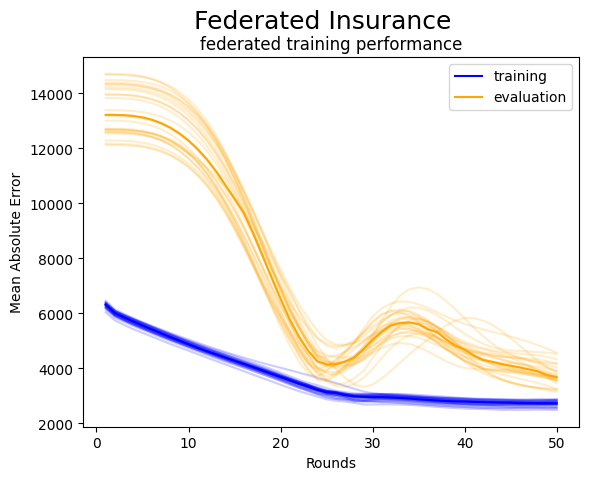

In [23]:
# plot train result (MAE)
# =======================

y = np.array([[hist['mean_absolute_error'] for hist in res['history']] for res in results_fed]).transpose()
yval = np.array([[hist['val_mean_absolute_error'] for hist in res['history']] for res in results_fed]).transpose()


xran = range(1,y.shape[0] + 1)
plt.plot(xran, y, color = 'blue', alpha = .2)
plt.plot(xran, np.quantile(y,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(xran, yval, color = 'orange', alpha = .2)
plt.plot(xran, np.quantile(yval,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.xlabel("Rounds")
plt.ylabel("Mean Absolute Error")
plt.suptitle('Federated Insurance', fontsize=18)
plt.title('federated training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_mae.png')
plt.show()

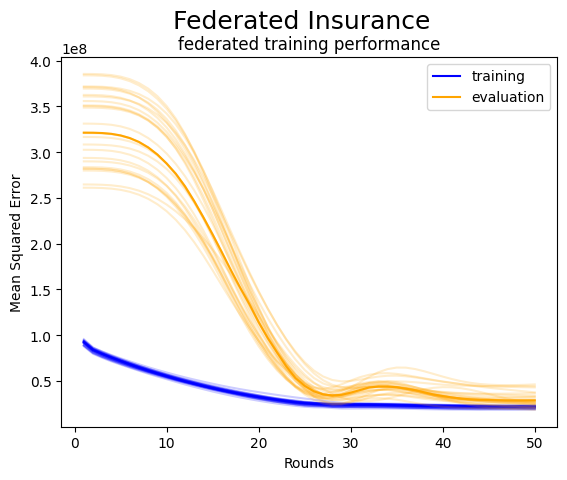

In [24]:
# plot train result (MSE)
# =======================

y = np.array([[hist['mean_squared_error'] for hist in res['history']] for res in results_fed]).transpose()
yval = np.array([[hist['val_mean_squared_error'] for hist in res['history']] for res in results_fed]).transpose()


xran = range(1,y.shape[0] + 1)
plt.plot(xran, y, color = 'blue', alpha = .2)
plt.plot(xran, np.quantile(y,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(xran, yval, color = 'orange', alpha = .2)
plt.plot(xran, np.quantile(yval,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.xlabel("Rounds")
plt.ylabel("Mean Squared Error")
plt.suptitle('Federated Insurance', fontsize=18)
plt.title('federated training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_mse.png')
plt.show()

### FED Test
---

In [25]:
# calculate test
# ==============

results_fed_test = []

model = keras_blueprint(compile = True)

i = 0
for train, test in tqdm.tqdm(list(evaluation.split(df, df.region))):
    data_test = df.loc[test]
    X_test, y_test = data_test[features_fed], data_test[target]
    
    # calculate test performance
    model_weights = results_fed[i]['process'].get_model_weights(results_fed[i]['state'])
    i += 1
    model_weights.assign_weights_to(model)
    
    perf_test = model.evaluate(X_test, y_test, verbose = 0)
    perf_test = dict(zip(model.metrics_names, perf_test))

    results_fed_test.append(perf_test)


100%|██████████| 25/25 [00:14<00:00,  1.76it/s]


In [26]:
# show test results
# =================

table2 = pd.DataFrame(results_fed_test)
table2 = table2.set_axis(['test_'+ col for col in table2.columns], axis = 1)

table2.to_csv(experiment_path + "results/performance_test.csv", sep = ";")
table2.describe()[1:].to_csv(experiment_path + "results/performance_test_overview.csv", sep = ";")
table_all_fed = pd.concat([table, table2], axis = 1)
table_all_fed.describe()[1:].to_csv(experiment_path + "results/performance_overview.csv", sep = ";")
table_all_fed.to_csv(experiment_path + "results/performance.csv", sep = ";")

table_all_fed.describe()[1:].transpose().round(4)

,mean,std,min,25%,50%,75%,max
mean_absolute_error,2.721242e+03,1.045462e+02,2.487060e+03,2.676819e+03,2.725348e+03,2.793870e+03,2.873921e+03
mean_squared_error,2.148627e+07,1.309649e+06,1.841550e+07,2.046647e+07,2.168002e+07,2.245725e+07,2.343150e+07
loss,2.151419e+07,1.301690e+06,1.848812e+07,2.048785e+07,2.170535e+07,2.246334e+07,2.351449e+07
num_examples,4.812000e+04,2.500000e+01,4.810000e+04,4.810000e+04,4.810000e+04,4.815000e+04,4.815000e+04
num_batches,3.782000e+02,4.082000e-01,3.780000e+02,3.780000e+02,3.780000e+02,3.780000e+02,3.790000e+02
val_mean_absolute_error,3.751573e+03,3.839753e+02,3.147538e+03,3.565328e+03,3.676179e+03,3.908816e+03,4.566275e+03
val_mean_squared_error,2.959006e+07,7.407283e+06,1.847655e+07,2.492448e+07,2.865781e+07,3.281315e+07,4.624708e+07
val_loss,3.005164e+07,7.710560e+06,1.873413e+07,2.513197e+07,2.923370e+07,3.359842e+07,4.795110e+07
val_num_examples,1.080000e+02,0.000000e+00,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02
val_num_batches,4.000000e+00,0.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00


## Centralized DNN
---

### Setup
---

Using 9 Features.

In [27]:
# experiment logging
# =============

experiment_name = '07_central_fix'

experiment_path = out_path + "/" + experiment_name + "/"
if not os.path.exists(experiment_path + 'logs'): os.makedirs(experiment_path + 'logs')
if not os.path.exists(experiment_path + 'models'): os.makedirs(experiment_path + 'models')
if not os.path.exists(experiment_path + 'results'): os.makedirs(experiment_path + 'results')

### CTR Train
---

In [28]:
# calculate training
# ==================

results_ctr = []

eval_ind = 0
for train, test in tqdm.tqdm(list(evaluation.split(df, df.region))):

    # Logging
    rep  = int(eval_ind / nfolds)
    fold = int(eval_ind % nfolds)
    eval_ind += 1
    id = "r" + str(rep) + "f" + str(fold)
    #print('======= rep %s - fold %s  =======' % (rep, fold))
    
    
    data_train = df.loc[train]
    X_train, y_train = data_train[features], data_train[target]

    model = keras_blueprint(nfeatures = len(features), compile = True)
    
    result = train_model(
        model, X_train, y_train,
        epochs = n_epochs, 
        #output_msr = "r2_score",
        callbacks = [CSVLogger(experiment_path + "logs/" + id + '_log.csv'  , separator =";")],
        seed = 42,
        verbose = False
    )
    model.save_weights(experiment_path + "models/" + id + '_weights.h5')

    results_ctr.append(result)


100%|██████████| 25/25 [16:47<00:00, 40.32s/it]


In [29]:
# show train results
# ==================

table = pd.DataFrame(
    [{key: val[-1] for key, val in hist.history.items()} for hist in results_ctr]
    ).assign(
    #r2_score    = lambda x: x.r2_score * 100,
    #val_r2_score = lambda x: x.val_r2_score * 100
)

table.describe()[1:].to_csv(experiment_path + "results/performance_train_overview.csv", sep = ";")
table.round(2)

,loss,mae,mean_squared_error,r2_score,val_loss,val_mae,val_mean_squared_error,val_r2_score
0,21626548.0,2757.34,21626548.0,0.84,29159864.0,2880.28,29159864.0,0.81
1,19210398.0,2495.15,19210398.0,0.87,20524956.0,2673.47,20524956.0,0.85
2,20410250.0,2650.53,20410250.0,0.86,25338486.0,2865.97,25338486.0,0.84
3,22505218.0,2851.87,22505218.0,0.84,28212952.0,3007.68,28212952.0,0.83
4,21713008.0,2729.77,21713008.0,0.84,23644974.0,2766.91,23644974.0,0.85
5,21725024.0,2846.02,21725024.0,0.85,29284214.0,3522.47,29284214.0,0.82
6,21764438.0,2854.46,21764438.0,0.84,26290300.0,3059.46,26290300.0,0.84
7,18076762.0,2378.65,18076762.0,0.87,17238680.0,2453.87,17238680.0,0.88
8,22138294.0,2774.63,22138294.0,0.84,29136608.0,3720.82,29136608.0,0.81
9,23556024.0,2680.43,23556024.0,0.84,24325584.0,3117.33,24325584.0,0.84


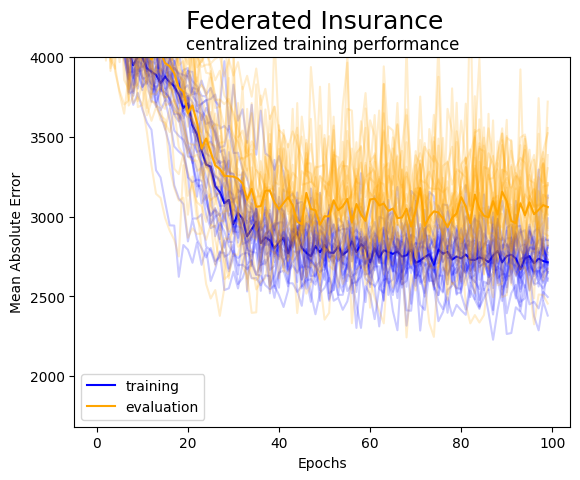

In [30]:
# plot train result (MAE)
# =======================

y1 = np.array([hist.history["mae"] for hist in results_ctr]).transpose()
y2 = np.array([hist.history["val_mae"] for hist in results_ctr]).transpose()

plt.plot(y1, color = 'blue', alpha = .2)
plt.plot(np.quantile(y1,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(y2, color = 'orange', alpha = .2)
plt.plot(np.quantile(y2,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.ylim([None, 4000])

plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.suptitle('Federated Insurance', fontsize = 18)
plt.title('centralized training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_mae.png')
plt.show()


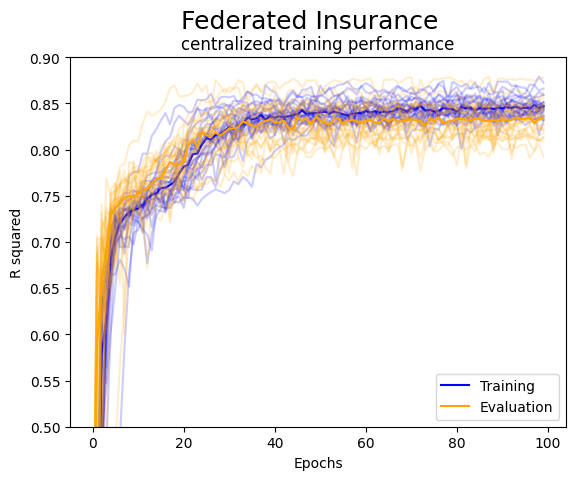

In [31]:
# plot train result (RSQ)
# =======================

y1 = np.array([hist.history["r2_score"] for hist in results_ctr]).transpose()
y2 = np.array([hist.history["val_r2_score"] for hist in results_ctr]).transpose()

plt.plot(y1, color = 'blue', alpha = .2)
plt.plot(np.quantile(y1,.5, axis = 1), label = 'Training', color = 'blue')
plt.plot(y2, color = 'orange', alpha = .2)
plt.plot(np.quantile(y2,.5, axis = 1), label = 'Evaluation', color = 'orange')
plt.ylim([0.5, 0.9])
plt.xlabel("Epochs")
plt.ylabel("R squared")
plt.suptitle('Federated Insurance', fontsize = 18)
plt.title('centralized training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_rsq.png')
plt.show()



### CTR Test
---

In [32]:
# compute test
# ============

results_test_ctr = []

i = 0
for train, test in tqdm.tqdm(list(evaluation.split(df, df.region))):
    data_test = df.loc[test]
    
    X_test, y_test = data_test[features], data_test[target]
    
    
    model = results_ctr[i].model
    i += 1
    perf_test  = model.evaluate(X_test, y_test, verbose = 0)
    perf_test = dict(zip(model.metrics_names, perf_test))
    results_test_ctr.append(perf_test)

100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


In [33]:
# show test results
# =================

table2 = pd.DataFrame(results_test_ctr)
table2 = table2.set_axis(['test_'+ col for col in table2.columns], axis = 1)


table2.describe()[1:].to_csv(experiment_path + "results/performance_test_overview.csv", sep = ";")

table_all_ctr = pd.concat([table, table2], axis = 1)
table_all_ctr.describe()[1:].to_csv(experiment_path + "results/performance_overview.csv", sep = ";")
table_all_ctr.to_csv(experiment_path + "results/performance.csv", sep = ";")
table_all_ctr.describe()[1:].transpose().round(2)

,mean,std,min,25%,50%,75%,max
loss,21638855.76,1175413.15,18076762.00,21479838.00,21756192.00,22209778.00,23556024.00
mae,2731.89,149.01,2378.65,2655.45,2713.00,2814.41,3131.35
mean_squared_error,21638855.76,1175413.15,18076762.00,21479838.00,21756192.00,22209778.00,23556024.00
r2_score,0.85,0.01,0.83,0.84,0.85,0.85,0.87
val_loss,25543048.00,3123957.95,17238680.00,23899802.00,26055084.00,27373386.00,30845704.00
val_mae,3057.81,294.00,2453.87,2865.97,3059.46,3208.30,3720.82
val_mean_squared_error,25543048.00,3123957.82,17238680.00,23899806.00,26055084.00,27373386.00,30845704.00
val_r2_score,0.83,0.02,0.79,0.82,0.83,0.85,0.88
test_loss,23947200.24,3895341.08,19051912.00,21171818.00,22816820.00,26182232.00,32744468.00
test_mae,2921.54,277.96,2415.64,2716.87,2938.53,3087.47,3485.93


## Comparison
---

In [34]:
# table of results
# ================

tab = pd.concat(
    [
    table_all_fed.loc[:,table_all_fed.columns.str.contains("mean|loss|mae|score")].describe(percentiles = []).assign(type = "federated")[1:3].rename(
        columns = {'mean_absolute_error': 'mae',
                   
                   'val_mean_absolute_error': 'val_mae',
                   
                   'test_mean_absolute_error': 'test_mae'
                   }
    ).transpose(),
    table_all_ctr.describe(percentiles = []).assign(type = "centralized")[1:3].transpose()
    ],
    axis = 1)


tab.loc[['type','loss', 'mae', 'mean_squared_error', 'r2_score', 
         'val_loss', 'val_mae', 'val_mean_squared_error', 'val_r2_score','test_loss',
         'test_mae', 'test_mean_squared_error', 'test_r2_score'
       ]]

,mean,std,mean,std
type,federated,federated,centralized,centralized
loss,21514186.0,1301690.25,21638855.76,1175413.151674
mae,2721.242188,104.546219,2731.888945,149.011656
mean_squared_error,21486270.0,1309648.875,21638855.76,1175413.151674
r2_score,NaN,NaN,0.846632,0.009899
val_loss,30051636.0,7710560.5,25543048.0,3123957.950846
val_mae,3751.572754,383.975342,3057.812217,293.995221
val_mean_squared_error,29590064.0,7407283.0,25543048.0,3123957.824242
val_r2_score,NaN,NaN,0.834506,0.018819
test_loss,26831630.32,3642671.57437,23947200.24,3895341.079045
